In [1]:
# import some libraries
import os,sys
import gempy as gp
from scipy.stats import hmean
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')

## Extract temperature data for MC-rejection
For this, we use the `borehole logs`function in shemat. Borehole logs are defined for `i` and `j` values:  
* 32, 15
* 79, 23
* 54, 35
* 50, 45

In [2]:
# i and j values need to be substracted by 1, as fortran starts to count at 1, and python at 0
bhole = np.array([[31, 14],
                 [78, 22],
                 [53, 34],
                 [49, 44]])

In [2]:
def load_borehole_log(datafile: str=None, z_asl: int=0):
    
    if z_asl > 0:
        z_asl = -z_asl
        
    header = ['temperature', 'hydraulic head', 'pressure', 'delz', 'uindex']
    
    data = np.loadtxt(datafile)
    log_file = pd.DataFrame(data=data, columns=header)
    log_file['z_asl'] = log_file['delz'].cumsum() + z_asl
    
    return log_file

def extractLogHDF(hdf_file: str=None, borehole_coordinate: list=[0,0], z_asl: int=0):
    
    if z_asl > 0:
        z_asl = -z_asl
        
    h5_file = h5py.File(hdf_file)
    log_data = {}
    log_data['temperature'] = h5_file['temp'][:, borehole_coordinate[1], borehole_coordinate[0]]
    log_data['hydraulic head'] = h5_file['head'][:, borehole_coordinate[1], borehole_coordinate[0]]
    log_data['pressure'] = h5_file['pres'][:, borehole_coordinate[1], borehole_coordinate[0]]
    log_data['uindex'] = h5_file['uindex'][:, borehole_coordinate[1], borehole_coordinate[0]]
    log_data['z_asl'] = h5_file['z'][:,0,0] + z_asl
    
    borehole_dataframe = pd.DataFrame.from_dict(log_data)
    
    return borehole_dataframe

import itertools as it
def export_shemat_suite_input_file(geo_model, lithology_block, units: pd.DataFrame=None, bcs_file: str=None, 
                                   data_file: str=None, borehole_logs: np.array=None,
                                   path: str=None, filename: str='geo_model_SHEMAT_input_erode'):
    """
    Method to export a 3D geological model as SHEMAT-Suite input-file for a conductive HT-simulation. 

    Args:
        path (str): Filepath for the exported input file (default './')
        filename (str): name of exported input file (default 'geo_model_SHEMAT_input')
    """
    # get model dimensions
    nx, ny, nz = geo_model.grid.regular_grid.resolution
    xmin, xmax, ymin, ymax, zmin, zmax = geo_model.solutions.grid.regular_grid.extent
    
    delx = (xmax - xmin)/nx
    dely = (ymax - ymin)/ny
    delz = (zmax - zmin)/nz
    
    # get unit IDs and restructure them
    #ids = np.round(geo_model.solutions.lith_block)
    #ids = ids.astype(int)
    ids = np.round(lithology_block)
    ids = ids.astype(int)
    
    liths = ids.reshape((nx, ny, nz))
    liths = liths.flatten('F')

    # group litho in space-saving way
    sequence = [len(list(group)) for key, group in it.groupby(liths)]
    unit_id = [key for key, group in it.groupby(liths)]
    combined = ["%s*%s" % (pair) for pair in zip(sequence,unit_id)]

    combined_string = " ".join(combined)
    
    # bcs
    with open(bcs_file, 'r') as file:
        bc_vals = file.read()
        file.seek(0)
        lines = len(file.readlines())
    
    # borehole logs
    if borehole_logs is not None:
        n_logs = len(borehole_logs)
        borehole_string = f"# borehole logs, records={n_logs} \n"
        for hole in range(n_logs):
            borehole_string += f"{borehole_logs[hole,0]}, {borehole_logs[hole,1]}, borehole{hole} \n"
    else:
        borehole_string = "!# borehole logs, records=0"
        
    if data_file is None:
        data_string = "!# data, records=0"
    else:
        with open(data_file, 'r') as file:
            data_vals = file.read()
            file.seek(0)
            data_lines = len(file.readlines())
        data_string = f"\n# data, records={data_lines}  !"
        data_string += data_vals
    # units
    unitstring = ""
    try:
        for index, rows in units.iterrows():
            unitstring += f"{rows['por']}    1.d0  1.d0  {rows['perm']}	 1.e-10  1.d0  1.d0  {rows['lz']}	0.  2077074.  10  2e-3	!{rows['surface']} \n" 	
    except:
        print("No units table found, filling in default values for petrophysical properties.")
        # get number of units and set units string
        units = geo_model.surfaces.df[['surface', 'id']]
        for index, rows in units.iterrows():
            unitstring += f"0.01d0    1.d0  1.d0  1.e-14	 1.e-10  1.d0  1.d0  3.74	0.  2077074.  10  2e-3	!{rows['surface']} \n" 	
        
    # input file as f-string
    fstring = f"""!==========>>>>> INFO
# Title
{filename}

# linfo
1 2 1 1

# runmode
1

# timestep control
0
1           1           0           0

# tunit
1
 
# time periods, records=1
0      60000000    200      lin
           
# output times, records=10
1
6000000
12000000
18000000
24000000
30000000
36000000
42000000
48000000
54000000
    
# file output: hdf vtk

# active temp

# PROPS=bas

# USER=none


# grid
{nx} {ny} {nz}

# delx
{nx}*{delx}

# dely
{ny}*{dely}

# delz
{nz}*{delz}

{borehole_string}

!==========>>>>> NONLINEAR SOLVER
# nlsolve
50 0

!==========>>>>> FLOW
# lsolvef (linear solver control)
1.d-12 64 500
# nliterf (nonlinear iteration control)
1.0d-10 1.0

!==========>>>>> TEMPERATURE
# lsolvet (linear solver control)
1.d-12 64 500
# nlitert (nonlinear iteration control)
1.0d-10 1.0

!==========>>>>> INITIAL VALUES
# temp init HDF5=temp_init.h5
!{nx*ny*nz}*15.0d0  

# head init HDF5=head_init.h5
!{nx*ny*nz}*7500

!==========>>>>> UNIT DESCRIPTION
!!
# units
{unitstring}

!==========>>>>>   define boundary properties
# temp bcd, simple=top, value=init

# temp bcn, simple=base, error=ignore
{nx*ny}*0.072

# head bcd, records={lines}
{bc_vals}

{data_string}

# uindex
{combined_string}"""

    if not path:
        path = './'
    if not os.path.exists(path):
        os.makedirs(path)

    f = open(path+filename, 'w+')
    
    f.write(fstring)
    f.close()
    
    print(f"Successfully exported geological model {filename} as SHEMAT-Suite input to "+path)        

In [4]:
h5_log = extractLogHDF('../models/20210319_MC_no_middle_filling/SHEMAT_PCT_base_model_temp_final.h5',
                       borehole_coordinate=bhole[0,:], z_asl=-6500)

In [5]:
h5_log

,temperature,hydraulic head,pressure,uindex,z_asl
0,234.200420,6878.434051,66.830584,12,-6437.5
1,230.043436,6890.726477,65.727134,12,-6312.5
2,225.908875,6902.609445,64.619676,12,-6187.5
3,221.796654,6914.092648,63.508303,12,-6062.5
4,217.706683,6925.185289,62.393107,12,-5937.5
5,213.638866,6935.896192,61.274173,12,-5812.5
6,209.593100,6946.233878,60.151585,12,-5687.5
7,205.569276,6956.206646,59.025425,12,-5562.5
8,201.567279,6965.822653,57.895772,12,-5437.5
9,197.586984,6975.089971,56.762705,12,-5312.5


In [6]:
h5_file = h5py.File('../models/20210319_MC_no_middle_filling/SHEMAT_PCT_base_model_temp_final.h5')

In [7]:
temps = h5_file['temp'][:,bhole[0,1], bhole[0,0]]

In [8]:
temp = h5_file['temp'][:,:,:]
head = h5_file['head'][:,:,:]
pres = h5_file['pres'][:,:,:]
uindex = h5_file['uindex'][:,:,:]



In [9]:
h5_file['z'][:,0,0]

array([  62.5,  187.5,  312.5,  437.5,  562.5,  687.5,  812.5,  937.5,
       1062.5, 1187.5, 1312.5, 1437.5, 1562.5, 1687.5, 1812.5, 1937.5,
       2062.5, 2187.5, 2312.5, 2437.5, 2562.5, 2687.5, 2812.5, 2937.5,
       3062.5, 3187.5, 3312.5, 3437.5, 3562.5, 3687.5, 3812.5, 3937.5,
       4062.5, 4187.5, 4312.5, 4437.5, 4562.5, 4687.5, 4812.5, 4937.5,
       5062.5, 5187.5, 5312.5, 5437.5, 5562.5, 5687.5, 5812.5, 5937.5,
       6062.5, 6187.5, 6312.5, 6437.5, 6562.5, 6687.5, 6812.5, 6937.5,
       7062.5, 7187.5, 7312.5, 7437.5])

In [37]:
log1 = load_borehole_log('../models/20210319_MC_no_middle_filling/SHEMAT_PCT_base_model_temp_final_borehole4.dat', z_asl=-6500)
log1_c = load_borehole_log('../models/20210319_MC_no_middle_filling/SHEMAT_PCT_base_model_coupled_final_borehole1.dat', z_asl=-6500)

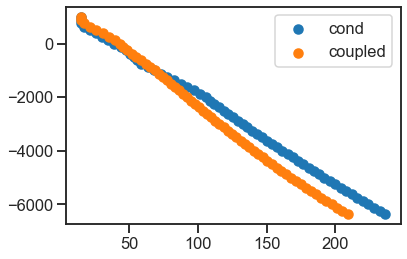

In [38]:
plt.scatter(log1['temperature'], log1['z_asl'], label='cond')
plt.scatter(log1_c['temperature'], log1_c['z_asl'], label='coupled')
plt.legend()

In [39]:
log1

,temperature,hydraulic head,pressure,delz,uindex,z_asl
0,236.485673,6880.241059,6.684828e+07,125.0,12.0,-6375.0
1,232.321543,6892.082406,6.574041e+07,125.0,12.0,-6250.0
2,228.184620,6903.497234,6.462837e+07,125.0,12.0,-6125.0
3,224.074775,6914.494942,6.351224e+07,125.0,12.0,-6000.0
4,219.991884,6925.084621,6.239212e+07,125.0,12.0,-5875.0
5,215.935836,6935.275096,6.126809e+07,125.0,12.0,-5750.0
6,211.906529,6945.074949,6.014024e+07,125.0,12.0,-5625.0
7,207.903874,6954.492526,5.900864e+07,125.0,12.0,-5500.0
8,203.927806,6963.535907,5.787338e+07,125.0,12.0,-5375.0
9,199.978288,6972.212827,5.673454e+07,125.0,12.0,-5250.0


In [20]:
borehole_cells = np.array([[32, 15], [79, 23], [54, 35], [50, 45]])
borehole_depth_ranges = ([[21,58], [31,55], [18,56], [27,56]])

(4, 2)

In [44]:
borehole_data = pd.read_csv('../models/20210319_MC_no_middle_filling/shemat_borehole_parameters.csv', sep=';')

In [48]:
import glob
borhole_files = glob.glob('../models/20210319_MC_no_middle_filling/borehole_data_for_conditioning/*_temp_final_*.dat')

In [62]:
borehole_data

,name,i,j,k_min,k_max,error,var_flag,flag
0,borehole1,32,15,21,58,0.5,2,1
1,borehole2,79,23,31,55,0.5,2,1
2,borehole3,54,35,18,56,0.5,2,1
3,borehole4,50,45,27,56,0.5,2,1


In [65]:
i = borhole_files[0]
name = i.split('_')[-1].split('.')[0]

In [70]:
params = borehole_data.query("name==@name")
pd.DataFrame(log1['temperature'][])

,temperature
0,236.485673
1,232.321543
2,228.184620
3,224.074775
4,219.991884
5,215.935836
6,211.906529
7,207.903874
8,203.927806
9,199.978288


In [76]:
params['error'].values[0]

0.5

In [77]:
boreholes = []
for i in borhole_files:
    bhole_name = i.split('_')[-1].split('.')[0]
    params = borehole_data.query("name==@bhole_name")
    log = load_borehole_log(i, z_asl=-6500)
    data = pd.DataFrame(log['temperature'][params['k_min'].values[0]:params['k_max'].values[0]])
    data['i'] = params['i'].values[0]
    data['j'] = params['j'].values[0]
    data['k'] = data.index
    data['error'] = params['error'].values[0]
    data['var_flag'] = params['var_flag'].values[0]
    data['flag'] = params['flag'].values[0]
    data['Name'] = "!"+bhole_name
    
    data = data.reindex(columns= ['temperature', 'error', 
                                  'i', 'j', 'k', 'var_flag', 
                                  'flag', 'Name'])
    boreholes.append(data)

In [79]:
allb = pd.concat(boreholes, ignore_index=True)

In [83]:
allb.to_csv('../models/20210319_MC_no_middle_filling/borehole_data_for_conditioning/all_boreholes_as_shemat_data.csv', index=False)

## Load lith_blocks

In [3]:
allb = pd.read_csv('../models/20210319_MC_no_middle_filling/borehole_data_for_conditioning/all_boreholes_as_shemat_data.csv')

In [6]:
model_path = '../models/20210319_MC_no_middle_filling/'

geo_model = gp.load_model('Graben_base_model', path=model_path,
                         recompile=False)

Active grids: ['regular']
Active grids: ['regular' 'topography']


In [10]:
model_shape = geo_model._grid.regular_grid.mask_topo.shape
topo_mask = geo_model._grid.regular_grid.mask_topo

In [7]:
lith_blocks = np.loadtxt('../../../data_var/lith_blocks_accepted_01042021')

In [23]:
accepted_reals = np.loadtxt('../../../data_var/accepted_realizations_01042021')

In [25]:
accepted_reals.shape

(626,)

In [18]:
lith_blocks_topo = np.array([])
n_iterations = lith_blocks.shape[0]
for i in lith_blocks:
    ids = np.round(i)
    ids = ids.astype(int)
    
    liths = ids.reshape(model_shape)
    liths[topo_mask] = np.unique(liths)[-1]+1
    lith_blocks_topo = np.append(lith_blocks_topo, liths)
lith_blocks_topo = lith_blocks_topo.reshape(n_iterations, -1)

In [12]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
9,Thrust1_south,Thrust1_series,1,#5DA629,1
10,Thrust2_south,Thrust2_series,1,#5DA629,2
0,Fault2,Fault2_series,1,#015482,3
1,Fault5,Fault5_series,1,#015482,4
2,Fault6,Fault6_series,1,#015482,5
6,Tertiary,Post_tectonic_series,1,#dbdbac,6
8,Pink,Post_tectonic_series,2,#e588f3,7
7,Orange,Post_tectonic_series,3,#ff792b,8
5,Mesozoic,Detachement,1,#725c9a,9
4,Upper-filling,Syn_tectonic_series2,1,#cfc199,10


In [14]:
units = geo_model.surfaces.df[['surface', 'id']]
params = {'por': np.array([1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 0.1, 0.05, 0.05, 0.01, 0.1, 0.05, 0.01]).T,
         'perm': np.array([1e-16, 1e-16, 1e-16, 1e-16, 1e-16, 1e-14, 1e-14, 1e-15, 1e-17, 1e-14, 1e-15, 1e-16]),
         'lz':   np.array([2.5, 2.5, 2.5, 2.5, 2.5, 2.3, 1.93, 2.9, 4.64, 2.03, 3.21, 3.1])}
units = units.join(pd.DataFrame(params, index=units.index))
air = {'surface': 'air',
       'id': units.shape[0]+1,
      'por': 1e-10,
      'perm': 1e-22,
      'lz': 100}
units = units.append(air, ignore_index=True)

In [27]:
shemade = ""
for c in range(n_iterations):
    model = lith_blocks_topo[c,:]
    real_acc = accepted_reals[c].astype(int)
    model_name = f"PCT_MC_{real_acc}"
    export_shemat_suite_input_file(geo_model, lithology_block=model, units=units, 
                                   bcs_file='../data/SHEMAT-Model_DTM', 
                                   data_file='../models/20210319_MC_no_middle_filling/borehole_data_for_conditioning/all_boreholes_as_shemat_data.csv',
                                   path='../models/20210319_MC_no_middle_filling/SHEMAT_MC/',
                                  filename=model_name)
    shemade += model_name + " \n"
with open("../models/20210319_MC_no_middle_filling/SHEMAT_MC/shemade.job", 'w') as jobfile:
    jobfile.write(shemade)

Successfully exported geological model PCT_MC_1 as SHEMAT-Suite input to ../models/20210319_MC_no_middle_filling/SHEMAT_MC/
Successfully exported geological model PCT_MC_2 as SHEMAT-Suite input to ../models/20210319_MC_no_middle_filling/SHEMAT_MC/
Successfully exported geological model PCT_MC_3 as SHEMAT-Suite input to ../models/20210319_MC_no_middle_filling/SHEMAT_MC/
Successfully exported geological model PCT_MC_4 as SHEMAT-Suite input to ../models/20210319_MC_no_middle_filling/SHEMAT_MC/
Successfully exported geological model PCT_MC_6 as SHEMAT-Suite input to ../models/20210319_MC_no_middle_filling/SHEMAT_MC/
Successfully exported geological model PCT_MC_8 as SHEMAT-Suite input to ../models/20210319_MC_no_middle_filling/SHEMAT_MC/
Successfully exported geological model PCT_MC_10 as SHEMAT-Suite input to ../models/20210319_MC_no_middle_filling/SHEMAT_MC/
Successfully exported geological model PCT_MC_11 as SHEMAT-Suite input to ../models/20210319_MC_no_middle_filling/SHEMAT_MC/
Succes

In [17]:
data = pd.DataFrame(log1['temperature'][21:58])

In [14]:
data['i'] = 53
data['j'] = 34
data['k'] = data.index
data['error'] = 0.5
data['var_flag'] = 2
data['flag'] = 1
data['Name'] = "!borehole1"

In [15]:
data = data.reindex(columns= ['temperature', 'error', 'i', 'j', 'k', 'var_flag', 'flag', 'Name'])

In [16]:
data

,temperature,error,i,j,k,var_flag,flag,Name
21,151.452338,0.5,53,34,21,2,1,!borehole3
22,147.735799,0.5,53,34,22,2,1,!borehole3
23,144.037254,0.5,53,34,23,2,1,!borehole3
24,140.356186,0.5,53,34,24,2,1,!borehole3
25,136.692013,0.5,53,34,25,2,1,!borehole3
26,133.044083,0.5,53,34,26,2,1,!borehole3
27,129.411696,0.5,53,34,27,2,1,!borehole3
28,125.794147,0.5,53,34,28,2,1,!borehole3
29,122.190709,0.5,53,34,29,2,1,!borehole3
30,118.600554,0.5,53,34,30,2,1,!borehole3


In [51]:
data.to_csv('../models/20210219_MC_ensemble/data_SHEMAT_bhole3.csv', index=False)

## Concatenate the borehole data

In [52]:
b1 = pd.read_csv('../models/20210219_MC_ensemble/data_SHEMAT_bhole1.csv')
b2 = pd.read_csv('../models/20210219_MC_ensemble/data_SHEMAT_bhole2.csv')
b3 = pd.read_csv('../models/20210219_MC_ensemble/data_SHEMAT_bhole3.csv')

In [53]:
frames = [b1, b2, b3]
allb = pd.concat(frames, ignore_index=True)

In [55]:
allb.to_csv('../models/20210219_MC_ensemble/data_SHEMAT_all_bholes.csv', index=False)

## add data to input files

In [3]:
def read_file(filename):
    """
    Open and read a SHEMAT-Suite input file
    **Arguments**:
        -*filename* = string: filename
    
    **Returns**:
        -List of lines in the file #better Dict??
    """
    try:
        file = open(filename, 'r')
    except IOError (nr, string_err):
        print("Cannot open file {} : {} Err# {}.".format(filename, string_err, nr))
        print("Please check if the file name and directory are correct.")
        raise IOError
    # check if number of entries is correct
    filelines = file.readlines()
    file.close()
    # set local vairables
    return filelines

def get(self, var_name, line=1):
    """
    Get the value of a scalar variable.
    Determines the value of a variable or parameter in the SHEMAT-Suite Input
    file.
    **Arguments**:
        - *var_name* = string: Name of the scalar variable
    **Optional keywords**:
        - *line* = Number of lines for multiline variables
    **Returns**
        String with variable
    """
    for (i,j) in enumerate(self.filelines):
        if var_name in j:
            if line == 1:
                return self.filelines[i+1]
                break
            else:
                lines = []
                for k in range(line):
                    lines.append(self.filelines[i+1])
                return lines
                break

In [4]:
def get_this(filename, var_name, line=1):
    try:
        file = open(filename, 'r')
    except IOError (nr, string_err):
        print("Cannot open file {} : {} Err# {}.".format(filename, string_err, nr))
        print("Please check if the file name and directory are correct.")
        raise IOError
    # check if number of entries is correct
    filelines = file.readlines()
    
    for (i, j) in enumerate(filelines):
        if var_name in j:
            if var_name == 'PROPS':
                return filelines[i].split('=')[1]
            if var_name == 'USER':
                return filelines[i].split('=')[1]
            if var_name == 'active':
                return filelines[i].split()[1:]
            if line == 1:
                return filelines[i + 1]
                break
            else:
                lines = []
                for k in range(line):
                    if filelines[i + 1 + k].startswith(("#","!","\n")):
                        return lines
                        break
                    lines.append(filelines[i + 1 + k])
                return lines
                break

In [5]:
import glob

In [12]:
files = glob.glob('../models/20210319_MC_no_middle_filling/SHEMAT_MC/PCT_MC_*')

In [13]:
files

['../models/20210319_MC_no_middle_filling/SHEMAT_MC/PCT_MC_549dat_cor',
 '../models/20210319_MC_no_middle_filling/SHEMAT_MC/PCT_MC_1dat_cor',
 '../models/20210319_MC_no_middle_filling/SHEMAT_MC/PCT_MC_880dat_cor',
 '../models/20210319_MC_no_middle_filling/SHEMAT_MC/PCT_MC_706dat_cor',
 '../models/20210319_MC_no_middle_filling/SHEMAT_MC/PCT_MC_983dat_cor',
 '../models/20210319_MC_no_middle_filling/SHEMAT_MC/PCT_MC_42dat_cor',
 '../models/20210319_MC_no_middle_filling/SHEMAT_MC/PCT_MC_428dat_cor',
 '../models/20210319_MC_no_middle_filling/SHEMAT_MC/PCT_MC_979dat_cor',
 '../models/20210319_MC_no_middle_filling/SHEMAT_MC/PCT_MC_846dat_cor',
 '../models/20210319_MC_no_middle_filling/SHEMAT_MC/PCT_MC_528dat_cor',
 '../models/20210319_MC_no_middle_filling/SHEMAT_MC/PCT_MC_264dat_cor',
 '../models/20210319_MC_no_middle_filling/SHEMAT_MC/PCT_MC_432dat_cor',
 '../models/20210319_MC_no_middle_filling/SHEMAT_MC/PCT_MC_820dat_cor',
 '../models/20210319_MC_no_middle_filling/SHEMAT_MC/PCT_MC_753dat_c

In [8]:
unit_file = get_this(files[2], 'data', line=128)

In [9]:
unit_file

['151.452337779402,0.5,32,15,21,2,1,!borehole1\n',
 '147.73579930228,0.5,32,15,22,2,1,!borehole1\n',
 '144.037253672605,0.5,32,15,23,2,1,!borehole1\n',
 '140.356185674902,0.5,32,15,24,2,1,!borehole1\n',
 '136.692012658893,0.5,32,15,25,2,1,!borehole1\n',
 '133.044082512963,0.5,32,15,26,2,1,!borehole1\n',
 '129.411695747861,0.5,32,15,27,2,1,!borehole1\n',
 '125.794147105729,0.5,32,15,28,2,1,!borehole1\n',
 '122.190708511671,0.5,32,15,29,2,1,!borehole1\n',
 '118.600554259159,0.5,32,15,30,2,1,!borehole1\n',
 '115.022682086232,0.5,32,15,31,2,1,!borehole1\n',
 '111.455849657642,0.5,32,15,32,2,1,!borehole1\n',
 '107.898552015529,0.5,32,15,33,2,1,!borehole1\n',
 '104.349133910911,0.5,32,15,34,2,1,!borehole1\n',
 '100.806326163099,0.5,32,15,35,2,1,!borehole1\n',
 '97.2690283709865,0.5,32,15,36,2,1,!borehole1\n',
 '93.7357576773011,0.5,32,15,37,2,1,!borehole1\n',
 '90.2043265871815,0.5,32,15,38,2,1,!borehole1\n',
 '86.6713854327527,0.5,32,15,39,2,1,!borehole1\n',
 '83.1315089089625,0.5,32,15,40,

In [17]:
tc_uf = np.round(np.random.normal(loc=3.03, scale=0.78),2)
tc_mf = np.round(np.random.normal(loc=2.87, scale=0.85),2)
tc_lf = np.round(np.random.normal(loc=1.94, scale=0.5),2)

uf = f'0.1    1.d0  1.d0  1e-14\t 1.e-10  1.d0  1.d0  {tc_uf}\t0.  2077074.  10  2e-3\t!Upper-filling \n'
mf = f'0.01    1.d0  1.d0  1e-16\t 1.e-10  1.d0  1.d0  {tc_mf}\t0.  2077074.  10  2e-3\t!Middle-filling \n'
lf = f'0.05    1.d0  1.d0  1e-15\t 1.e-10  1.d0  1.d0  {tc_lf}\t0.  2077074.  10  2e-3\t!Lower-filling \n'

unit_file[9:12] = uf, mf, lf

In [20]:
unit_file

['178.28938547402802,0.5,32,15,19,2,1,!borehole1\n',
 '173.777188401397,0.5,32,15,20,2,1,!borehole1\n',
 '169.277829013701,0.5,32,15,21,2,1,!borehole1\n',
 '164.79183898481,0.5,32,15,22,2,1,!borehole1\n',
 '160.319868935255,0.5,32,15,23,2,1,!borehole1\n',
 '155.86249033166402,0.5,32,15,24,2,1,!borehole1\n',
 '151.420003812109,0.5,32,15,25,2,1,!borehole1\n',
 '146.992535045352,0.5,32,15,26,2,1,!borehole1\n',
 '142.580620396946,0.5,32,15,27,2,1,!borehole1\n',
 '138.186137836017,0.5,32,15,28,2,1,!borehole1\n',
 '133.811878118642,0.5,32,15,29,2,1,!borehole1\n',
 '129.46016204679,0.5,32,15,30,2,1,!borehole1\n',
 '125.13144987104799,0.5,32,15,31,2,1,!borehole1\n',
 '120.823296348444,0.5,32,15,32,2,1,!borehole1\n',
 '116.53018981391199,0.5,32,15,33,2,1,!borehole1\n',
 '112.246203645012,0.5,32,15,34,2,1,!borehole1\n',
 '107.97624475428101,0.5,32,15,35,2,1,!borehole1\n',
 '103.73225238914499,0.5,32,15,36,2,1,!borehole1\n',
 '99.5253808920435,0.5,32,15,37,2,1,!borehole1\n',
 '95.3643790641434,0.

In [ ]:
# create a dict of find keys and replace values
findlines = open('find.txt').read().split('\n')
replacelines = open('replace.txt').read().split('\n')
find_replace = dict(zip(findlines, replacelines))

with open('data.txt') as data:
    with open('new_data.txt', 'w') as new_data:
        for line in data:
            for key in find_replace:
                if key in line:
                    line = line.replace(key, find_replace[key])
            new_data.write(line)

In [69]:
# replace units with random ones
shemade = ""
for fid in files:
    if fid[-1] != 't':
        unit_file = get_this(fid, 'units', line=14)
        #unit_stro = "".join(unit_file)
        ufo, mfo, lfo = unit_file[9:12]
        
        tc_uf = np.round(np.random.normal(loc=3.03, scale=0.78),2)
        tc_mf = np.round(np.random.normal(loc=1.93, scale=0.55),2)
        tc_lf = np.round(np.random.normal(loc=3.21, scale=0.6),2)
        #print(tc_uf, tc_mf, tc_lf)
        uf = f'0.1    1.d0  1.d0  1e-14\t 1.e-10  1.d0  1.d0  {tc_uf}\t0.  2077074.  10  2e-3\t!Upper-filling \n'
        mf = f'0.01    1.d0  1.d0  1e-16\t 1.e-10  1.d0  1.d0  {tc_mf}\t0.  2077074.  10  2e-3\t!Middle-filling \n'
        lf = f'0.05    1.d0  1.d0  1e-15\t 1.e-10  1.d0  1.d0  {tc_lf}\t0.  2077074.  10  2e-3\t!Lower-filling \n'
        #print(lf)
        find_replace = dict(zip([ufo, mfo, lfo], [uf, mf, lf]))
        
        with open(fid, 'r') as f:
            lines = f.readlines()
        
        with open(fid+'var_TCt', 'w') as nf:
            for line in lines:
                for key in find_replace:
                    line = line.replace(key, find_replace[key])
                nf.write(line)
        model_name = fid.split('/')[-1]
        shemade += model_name + "var_TCt \n"
        
with open("../models/20210219_MC_ensemble/shemade_TCt.job", 'w') as jobfile:
    jobfile.write(shemade)


In [61]:
unit_stro

'1e-10    1.d0  1.d0  1e-16\t 1.e-10  1.d0  1.d0  2.5\t0.  2077074.  10  2e-3\t!Thrust1_south \n1e-10    1.d0  1.d0  1e-16\t 1.e-10  1.d0  1.d0  2.5\t0.  2077074.  10  2e-3\t!Thrust2_south \n1e-10    1.d0  1.d0  1e-16\t 1.e-10  1.d0  1.d0  2.5\t0.  2077074.  10  2e-3\t!Fault2 \n1e-10    1.d0  1.d0  1e-16\t 1.e-10  1.d0  1.d0  2.5\t0.  2077074.  10  2e-3\t!Fault5 \n1e-10    1.d0  1.d0  1e-16\t 1.e-10  1.d0  1.d0  2.5\t0.  2077074.  10  2e-3\t!Fault6 \n0.1    1.d0  1.d0  1e-14\t 1.e-10  1.d0  1.d0  2.3\t0.  2077074.  10  2e-3\t!Tertiary \n0.05    1.d0  1.d0  1e-14\t 1.e-10  1.d0  1.d0  1.93\t0.  2077074.  10  2e-3\t!Pink \n0.05    1.d0  1.d0  1e-15\t 1.e-10  1.d0  1.d0  2.9\t0.  2077074.  10  2e-3\t!Orange \n0.01    1.d0  1.d0  1e-17\t 1.e-10  1.d0  1.d0  4.64\t0.  2077074.  10  2e-3\t!Mesozoic \n0.1    1.d0  1.d0  1e-14\t 1.e-10  1.d0  1.d0  3.03\t0.  2077074.  10  2e-3\t!Upper-filling \n0.01    1.d0  1.d0  1e-16\t 1.e-10  1.d0  1.d0  1.93\t0.  2077074.  10  2e-3\t!Middle-filling \n0.05

In [62]:
lines

['!==========>>>>> INFO\n',
 '# Title\n',
 'PCT_MC_80\n',
 '\n',
 '# linfo\n',
 '1 2 1 1\n',
 '\n',
 '# runmode\n',
 '1\n',
 '\n',
 '# timestep control\n',
 '0\n',
 '1           1           0           0\n',
 '\n',
 '# tunit\n',
 '1\n',
 ' \n',
 '# time periods, records=1\n',
 '0      60000000    200      lin\n',
 '           \n',
 '# output times, records=10\n',
 '1\n',
 '6000000\n',
 '12000000\n',
 '18000000\n',
 '24000000\n',
 '30000000\n',
 '36000000\n',
 '42000000\n',
 '48000000\n',
 '54000000\n',
 '    \n',
 '# file output: hdf vtk\n',
 '\n',
 '# active temp\n',
 '\n',
 '# PROPS=bas\n',
 '\n',
 '# USER=none\n',
 '\n',
 '\n',
 '# grid\n',
 '100 50 60\n',
 '\n',
 '# delx\n',
 '100*280.0\n',
 '\n',
 '# dely\n',
 '50*280.0\n',
 '\n',
 '# delz\n',
 '60*125.0\n',
 '\n',
 '!# borehole logs, records=0\n',
 '\n',
 '!==========>>>>> NONLINEAR SOLVER\n',
 '# nlsolve\n',
 '50 0\n',
 '\n',
 '!==========>>>>> FLOW\n',
 '# lsolvef (linear solver control)\n',
 '1.d-12 64 500\n',
 '# nliterf (non

In [11]:
shemade = ""
for fid in files:
    if fid[-1] != 't':
        with open(fid, 'r') as f:
            lines = f.readlines()

        with open(fid+'_dat', 'w') as f:
            for line in lines:
                line = line.replace('# data, records=129  !temperature,error,i,j,k,var_flag,flag,Name\n', 
                                '# data, records=128  !temperature,error,i,j,k,var_flag,flag,Name\n')
                f.write(line)
        model_name = fid.split('/')[-1]
        shemade += model_name + "_dat \n"
        
with open("../models/20210319_MC_no_middle_filling/SHEMAT_MC/shemade_cor.job", 'w') as jobfile:
    jobfile.write(shemade)

In [71]:
datafile = '../models/20210219_MC_ensemble/data_SHEMAT_all_bholes.csv'
with open(datafile, 'r') as file:
    data_vals = file.read()
data_string = f"\n# data, records={len(allb)}  !"
data_string += data_vals

In [72]:
data_string

'# data, records=96\n!temperature,error,i,j,k,var_flag,flag,Name\n178.28938547402802,0.5,32,15,19,2,1,!borehole1\n173.777188401397,0.5,32,15,20,2,1,!borehole1\n169.277829013701,0.5,32,15,21,2,1,!borehole1\n164.79183898481,0.5,32,15,22,2,1,!borehole1\n160.319868935255,0.5,32,15,23,2,1,!borehole1\n155.86249033166402,0.5,32,15,24,2,1,!borehole1\n151.420003812109,0.5,32,15,25,2,1,!borehole1\n146.992535045352,0.5,32,15,26,2,1,!borehole1\n142.580620396946,0.5,32,15,27,2,1,!borehole1\n138.186137836017,0.5,32,15,28,2,1,!borehole1\n133.811878118642,0.5,32,15,29,2,1,!borehole1\n129.46016204679,0.5,32,15,30,2,1,!borehole1\n125.13144987104799,0.5,32,15,31,2,1,!borehole1\n120.823296348444,0.5,32,15,32,2,1,!borehole1\n116.53018981391199,0.5,32,15,33,2,1,!borehole1\n112.246203645012,0.5,32,15,34,2,1,!borehole1\n107.97624475428101,0.5,32,15,35,2,1,!borehole1\n103.73225238914499,0.5,32,15,36,2,1,!borehole1\n99.5253808920435,0.5,32,15,37,2,1,!borehole1\n95.3643790641434,0.5,32,15,38,2,1,!borehole1\n91.2

In [61]:
for f in files:
    with open(f, "a") as myfile:
        myfile.write(data_string)

In [36]:
def delete_line_by_condition(original_file, condition):
    """ In a file, delete the lines at line number in given list"""
    dummy_file = original_file + '.bak'
    is_skipped = False
    # Open original file in read only mode and dummy file in write mode
    with open(original_file, 'r') as read_obj, open(dummy_file, 'w') as write_obj:
        # Line by line copy data from original file to dummy file
        for line in read_obj:
            # if current line matches the given condition then skip that line
            if condition(line) == False:
                write_obj.write(line)
            else:
                is_skipped = True
    # If any line is skipped then rename dummy file as original file
    if is_skipped:
        os.remove(original_file)
        os.rename(dummy_file, original_file)
    else:
        os.remove(dummy_file)
        
def delete_line_with_word(file_name, word):
    """Delete lines from a file that contains a given word / sub-string """
    delete_line_by_condition(file_name, lambda x : word in x )

In [42]:
delete_line_with_word(file_name=files[0], word=',0.5,')

TypeError: 'in <string>' requires string as left operand, not list

In [41]:
files[0]

'../models/20210219_MC_ensemble/PCT_MC_4var_TCt'